In [1]:
import TradingData
import requests
import pandas as pd
from matplotlib import pyplot
import datetime
import os
pd.options.mode.chained_assignment = None 

if not os.path.exists('./Data'):
    os.makedirs('Data')

In [2]:
df = pd.read_excel("BTCHistory.xlsx")
btchistory = dict(zip(df["Date"], df["BTC Price"]))
def getBTCPriceAtDate(date: str) -> float:
    response = requests.get("https://api.coindesk.com/v1/bpi/historical/close.json",
                            params={"start":date, "end":date}
                           )
    return(response.json()["bpi"][date])

def addWeights(df: pd.DataFrame, N: int) -> pd.DataFrame:
    starting_market_value = df["Market Cap"].sum()
    weights = []
    for i in df["Market Cap"]:
        weights.append(i / starting_market_value)
#         weights.append(1/N)
    weights.reverse()
    df["Weights"] = weights
    return df

def addInvestments(df: pd.DataFrame, dollars: float) -> pd.DataFrame:
    df["Allocated ($)"] = dollars * df["Weights"]
    df["Investments"] = df["Allocated ($)"] / df["Price"]
    return df

def numpyToDateTime(x):
    return datetime.datetime.utcfromtimestamp(x.tolist()/1e9)

def rebalanceAccount(portfolio: pd.DataFrame, market: pd.DataFrame, N: int) -> pd.DataFrame:
    newdf = market.merge(portfolio, on="Symbol", suffixes=["", "_old"])
    newdf["New_Amount"] = newdf["Investments"] * newdf["Price"]
    portfolio_worth = newdf.New_Amount.sum()

    topN_df = market.head(N)
    topN_df = addWeights(topN_df, N)
    topN_df = addInvestments(topN_df, portfolio_worth)
    
    return topN_df

def addHistoricData(symbol: str, container: dict):
    if symbol == "MIOTA":
        symbol = "IOT"
    if symbol not in container and symbol != "BTC":
        try:
            if os.path.isfile("./Data/{}.xlsx".format(symbol)):
                df = pd.read_excel("./Data/{}.xlsx".format(symbol))
                container[symbol] = dict(zip(df["time"], df["close"]))
            else:
                print("Downloading data for {}".format(symbol))
                df = TradingData.getHistoricDataLong(symbol)
                container[symbol] = dict(zip(df["time"], df["close"]))
                df.to_excel("./Data/{}.xlsx".format(symbol))
        except:
            print("{} does not exist on CryptoCompare API", symbol)
            
def calculatePortfolioValue(df: pd.DataFrame, curr_date: datetime.date, historicdata: dict) -> float:
    val = 0
    for name in df.Name.unique():
        dateString = curr_date.strftime("%Y-%m-%d")
        investment = df[df.Name == name].iloc[0]["Investments"]
        
        symbol = getCryptoCompareSymbol(name)
        
        if symbol != "BTC":
#             curr_price_btc = historicdata[symbol].query("time == {}".format(dateString.replace("-",""))).iloc[0]["close"]
            curr_price_inbtc = historicdata[symbol][pd.to_datetime(curr_date)]
            curr_btc_price = btchistory[curr_date]

            value = investment * curr_price_inbtc * curr_btc_price
        else:
#             value = investment * getBTCPriceAtDate(dateString)
            value = investment * btchistory[curr_date]
        val += value
    return(val)

crypo_compare_conversion = pd.read_excel("CryptoCompare_NameToTicker.xlsx")
def getCryptoCompareSymbol(coinName: str) -> str:
    if coinName == "Dash":
        return "DASH"
    if coinName == "Bytecoin":
        return "BCN"
    if coinName == "Stellar Lumens":
        coinName = "Stellar"
    if coinName == "TRON":
        coinName = "Tronix"
    direct = crypo_compare_conversion[crypo_compare_conversion.CoinName.str.lower() == coinName.lower()]
    if len(direct) == 1:
        return direct["Symbol"].values[0]
    else:
        match = crypo_compare_conversion[crypo_compare_conversion.CoinName.str.contains(coinName, case=False)]
        if len(match) > 1:
            raise Exception('Multiple values for CoinName: {} are found'.format(coinName))
        elif len(match) < 1:
            raise Exception('No values were found for CoinName: {}'.format(coinName))
        else:
            return match["Symbol"].values[0]

In [3]:
## get market cap data
MARKETCAP = pd.read_excel("MarketCap.xlsx")
MARKETCAP["Date"] = pd.to_datetime(MARKETCAP["Date"])

columns = ["Market Cap", "Price", "Volume (24h)", "Circulating Supply"]
for column in columns:
    MARKETCAP[column] = MARKETCAP[column].replace('[?]','0', regex=True)
    MARKETCAP[column] = MARKETCAP[column].replace('[\$,\*]', '', regex=True).astype(float)

delcolumns = ["% 1h", "% 24h", "% 7d", "Circulating Supply", "Volume (24h)"]
for column in delcolumns:
    del MARKETCAP[column]
    
#=====================================================
N = 20

dates = MARKETCAP.Date.unique()
dates.sort()

starting_market = MARKETCAP[(MARKETCAP.Date == dates[0]) & (MARKETCAP.Name != "Tether")].head(N)

historicdata = {}
for name in starting_market.Name.unique():
    symbol = getCryptoCompareSymbol(name)
    addHistoricData(symbol, historicdata)

Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.
Rebalanced.


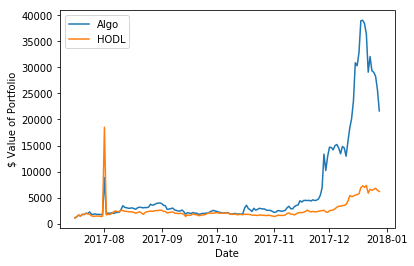

In [4]:
INITIAL_INV = 1000

dates = MARKETCAP.Date.unique()
dates.sort()

dates = [numpyToDateTime(i) for i in dates]
curr_date = dates[0]
# initial_btc = INITIAL_INV / getBTCPriceAtDate(str(dates[0]).split('T')[0])
curr_investments = addInvestments(addWeights(starting_market, N), INITIAL_INV)
starting_investments = curr_investments

date_range = []
hodl = []
nohold = []
for day in range(0, (datetime.datetime.now() - dates[0]).days):
    date_range.append(curr_date)
    hodl.append(calculatePortfolioValue(starting_investments, curr_date, historicdata))    
    
    if curr_date in dates:
        curr_market = MARKETCAP[(MARKETCAP.Date == curr_date) & (MARKETCAP.Name != "Tether")]
        curr_investments = rebalanceAccount(curr_investments, curr_market, N)
        for name in curr_investments.Name.unique():
            symbol = getCryptoCompareSymbol(name)
            addHistoricData(symbol, historicdata)
        print("Rebalanced.")
        
        nohold.append(calculatePortfolioValue(curr_investments, curr_date, historicdata))
    else:
        nohold.append(calculatePortfolioValue(curr_investments, curr_date, historicdata))
    curr_date = curr_date + datetime.timedelta(days=1)
pyplot.plot(date_range, nohold)
pyplot.plot(date_range, hodl)
pyplot.legend(["Algo", "HODL"])
pyplot.ylabel("$ Value of Portfolio")
pyplot.xlabel("Date")
pyplot.show()